# Import all libraries


In [1]:
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='once')

## Reading and preprocessing dataframe

In [2]:
def preprocessWeather(path_url):
    df = pd.read_csv(path_url)
    df.columns = df.columns.str.replace(' ', '')
    df[['FH', 'T']] = df[['FH', 'T']] / 10
    df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    df['date'] = df['YYYYMMDD'] +  pd.to_timedelta(df['HH'], unit='h')
    df.drop(columns = ['#STN', 'DD', 'FF', 'FX', 'T10N', 'TD', 'Q', 'RH', 
                       'P', 'VV', 'U', 'WW', 'IX', 'HH', 'YYYYMMDD'], inplace=True)
    df.set_index('date', inplace=True)
    return df

def preprocessResono(path_url):
    df = pd.read_csv(path_url)
    return df

In [3]:
df_Weather2020 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2011-2020.txt")
df_Weather2021 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2021-2030.txt")

df_Resono_Oct_Dec = preprocessResono("Resono_Oct_Dec.csv")

C:\Users\olivi\anaconda3\envs\my-r-env\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (15,16,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [4]:
df_weather = pd.concat([df_Weather2020, df_Weather2021], axis=0)
df_weather = df_weather.loc['2020-10': '2022-01-01 00:00']

cols_int = ['SQ', 'DR', 'N', 'M', 'R', 'S', 'O', 'Y']
cols_float = ['FH', 'T']

df_weather[cols_float] = df_weather[cols_float].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather[cols_int] = df_weather[cols_int].apply(pd.to_numeric, errors='coerce', axis=1)

In [5]:
df_Resono = df_Resono_Oct_Dec.drop(columns = ["Unnamed: 0", "Resono-ID", "End", "Locationcode"])
df_Resono['Start'] = pd.to_datetime(df_Resono['Start'])
df_Resono['Start'] = pd.to_datetime(df_Resono['Start'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [6]:
df_Resono_index = df_Resono.set_index('Start')
df_Resono_index = df_Resono_index.loc['2020-10':]

In [7]:
merged = pd.merge(df_Resono_index, df_weather, left_index=True, right_index=True, how='left')

In [8]:
# Some entries are duplicate, so we need to take the average
df_average_visits = df_Resono 
df_average_visits['Start'] = pd.to_datetime(df_average_visits['Start'])
df_average_visits = df_average_visits.groupby(['Location', 'Start']).mean().reset_index()
df_average_visits['End'] = df_average_visits['Start'] + dt.timedelta(minutes=14, seconds=59)
df_average_visits['Visits'] = df_average_visits['Visits'].astype(int)

<AxesSubplot:xlabel='Start', ylabel='Visits'>

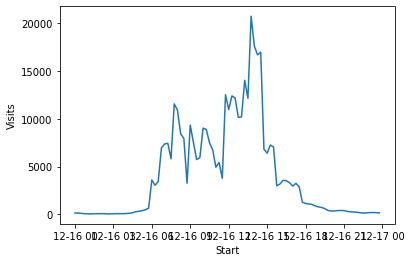

In [9]:
test = df_Resono_index[df_Resono_index.Location == 'Centraal station'].loc['2020 December 16']
test = test.reset_index()
test.drop_duplicates(subset=['Start'], inplace=True)
test.set_index('Start', inplace=True)
test.resample('1H').sum()
sns.lineplot(data=test, x=test.index, y='Visits')

In [29]:
df_Resono_index

,Location,Visits,Start_Dates,Start_Time,End_Dates,End_Time
Start,,,,,,
2020-10-01 00:00:00,Planciusbuurt Zuid,13,2020-10-01,00:00:00,2020-10-01,00:14:59
2020-10-01 00:00:00,Marnixbuurt Midden,93,2020-10-01,00:00:00,2020-10-01,00:14:59
2020-10-01 00:00:00,Planciusbuurt Noord,51,2020-10-01,00:00:00,2020-10-01,00:14:59
2020-10-01 00:00:00,Kleine Gartmanplantsoen,21,2020-10-01,00:00:00,2020-10-01,00:14:59
2020-10-01 00:00:00,Leidsebuurt Noordwest,55,2020-10-01,00:00:00,2020-10-01,00:14:59
...,...,...,...,...,...,...
2020-12-31 23:30:00,Station RAI,12,2020-12-31,23:30:00,2020-12-31,23:44:59
2020-12-31 23:15:00,Muiderpoortstation,18,2020-12-31,23:15:00,2020-12-31,23:29:59
2020-12-31 23:30:00,Muiderpoortstation,14,2020-12-31,23:30:00,2020-12-31,23:44:59
